In [8]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate
from keras.callbacks import TensorBoard

In [45]:

# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(64, return_sequences=False)(inputs_list[i]) )
        
    output = concatenate(layers) 
    output = Dense(3, activation='softmax', name='IsSpike')(output)
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

data_length = 20


### Model Shape

* Price  ----------> LSTM --\
* Google Trends ---> LSTM ---> Dense Layer -> Softmax -> Output: Is Spike (1,0,-1) 
* Volume ----------> LSTM --/




* Input: Price, Google Trends, and Volume for time t0-t9 (10 hours of data) 
* Output: Is Spike (1,0,-1) for t10 
    * Using 10 hours (t0-t9) of Price, Google Trends, and Volume to predict the price movement at t11 (t10)

In [46]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df_v3.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]

# lag inputs depending on data_length 
df['Price_lagged'] = df['Close']#.shift(data_length)
df['Volume_BTC'] = df['Volume_(BTC)']#.shift(data_length)
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']#.shift(data_length)

df = df.dropna()
cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']

# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)

# Min-Max Scale 

scalers = {}
datas = [] 

df_scaled = pd.DataFrame(columns=cols)


############################################################
#  Fix below - I am scaling the whole data set together, when I should scale the train and test datasets separately
############################################################

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = data[0]
    
df_scaled['Is Spike'] = df['Is Spike']
df_scaled.dropna(inplace=True)
display(df_scaled.head())
display(df_scaled.tail())

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,Is Spike
1,0.776791,0.471970,0.484557,0.484557,1.0
2,0.463316,0.439996,0.538331,0.538331,1.0
3,0.725079,0.529463,0.520715,0.520715,-1.0
4,0.210661,0.416611,0.566098,0.566098,0.0
5,0.594148,0.445509,0.568881,0.568881,-1.0


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,Is Spike
30285,0.455905,0.449846,0.546519,0.546519,1.0
30286,0.308749,0.457405,0.549938,0.549938,-1.0
30287,0.632915,0.453625,0.563428,0.563428,0.0
30288,0.629822,0.434124,0.506657,0.506657,0.0
30289,0.564642,0.445374,0.493535,0.493535,-1.0


In [47]:
from keras.utils.np_utils import to_categorical

# split and reshape data to feed into RNN

# X_timestamp = df_scaled['Timestamp'].values
X_volume = df_scaled['Volume_BTC'].values
X_trends = df_scaled['Bitcoin_Adj'].values
X_lagged_price = df_scaled['Price_lagged'].values

Y_is_spike = df_scaled['Is Spike'].values 

train_size = int(len(X_volume) * 0.85)
train_size = int(train_size/data_length) * data_length

test_size_index = int(len(X_volume)/data_length)*data_length

X_train_volume = []
X_test_volume = [] 
X_train_trends = []
X_test_trends = []
X_train_lagged_price = []
X_test_lagged_price = []
Y_train_is_spike = [] 
Y_test_is_spike = [] 

for i in range(train_size-data_length):
    vol_temp = []
    trends_temp = []
    price_temp = []
    for j in range(data_length):
        vol_temp.append(X_volume[i+j])
        trends_temp.append(X_trends[i+j])
        price_temp.append(X_lagged_price[i+j])
    X_train_volume.append(vol_temp)
    X_train_trends.append(trends_temp)
    X_train_lagged_price.append(price_temp)
    
    Y_train_is_spike.append(Y_is_spike[i+data_length])

for i in range(test_size_index-train_size-data_length):
    vol_temp = []
    trends_temp = [] 
    price_temp = [] 
    for j in range(data_length):
        vol_temp.append(X_volume[train_size+i+j])
        trends_temp.append(X_trends[train_size+i+j])
        price_temp.append(X_lagged_price[train_size+i+j])
    X_test_volume.append(vol_temp)
    X_test_trends.append(trends_temp)
    X_test_lagged_price.append(price_temp)
    
    Y_test_is_spike.append(Y_is_spike[train_size+i+data_length])
    
X_train_volume = np.array(X_train_volume)
X_test_volume =  np.array(X_test_volume)
X_train_trends = np.array(X_train_trends)
X_test_trends = np.array(X_test_trends)
X_train_lagged_price = np.array(X_train_lagged_price)
X_test_lagged_price = np.array(X_test_lagged_price)
Y_train_is_spike =  np.array(Y_train_is_spike)
Y_test_is_spike = np.array(Y_test_is_spike)
    
    
Y_train_is_spike_onehot = to_categorical(Y_train_is_spike, num_classes=3)
Y_test_is_spike_onehot = to_categorical(Y_test_is_spike,num_classes=3)
display(Y_train_is_spike)

# y = pd.DataFrame(Y_train_is_spike_onehot)
# y['actual'] = Y_train_is_spike
# display(y.head(25))
    
# display(X_train_trends.shape)
# display(Y_train_is_spike.shape)

#display(X_train_lagged_price)
#display(Y_train_is_spike)

# df_train = pd.DataFrame(X_train_lagged_price)
# df_train['label'] = Y_train_is_spike
# display(df_train.tail(20))
# display(df_scaled.head(30))
# display(df_train.head(30))

#--------------------------------

# # X_train_timestamp, X_test_timestamp = X_timestamp[:train_size], X_timestamp[train_size:test_size_index ]
# X_train_volume, X_test_volume = X_volume[:train_size], X_volume[train_size:test_size_index ]
# X_train_trends, X_test_trends = X_trends[:train_size], X_trends[train_size:test_size_index ]
# X_train_lagged_price, X_test_lagged_price = X_lagged_price[:train_size], X_lagged_price[train_size:test_size_index ]

# # becasue I lagged the x inputs, I should forward the Y's by the data_length as well 
# Y_train_is_spike, Y_test_is_spike = Y_is_spike[data_length:train_size], Y_is_spike[train_size+data_length:test_size_index ]


# # X.shape is (samples, timesteps, dimension) 
# # timestemps is 15, samples is just however many nobs there are (but it doesn't matter, so it should be None)


X_train_volume = np.reshape(X_train_volume, (X_train_volume.shape[0],data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (X_train_trends.shape[0],data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (X_train_lagged_price.shape[0], data_length, 1))

X_test_volume = np.reshape(X_test_volume, (X_test_volume.shape[0],data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (X_test_trends.shape[0],data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (X_test_lagged_price.shape[0],data_length,1))


# # X_train_timestamp = np.reshape(X_train_timestamp, (int(X_train_timestamp.shape[0]/data_length),data_length,1) ) 
# X_train_volume = np.reshape(X_train_volume, (int(X_train_volume.shape[0]/data_length),data_length,1) ) 
# X_train_trends = np.reshape(X_train_trends, (int(X_train_trends.shape[0]/data_length),data_length,1) ) 
# X_train_lagged_price = np.reshape(X_train_lagged_price, (int(X_train_lagged_price.shape[0]/data_length), data_length, 1))

# # X_test_timestamp = np.reshape(X_test_timestamp, (int(X_test_timestamp.shape[0]/data_length),data_length,1) ) 
# X_test_volume = np.reshape(X_test_volume, (int(X_test_volume.shape[0]/data_length),data_length,1) ) 
# X_test_trends = np.reshape(X_test_trends, (int(X_test_trends.shape[0]/data_length),data_length,1) )  
# X_test_lagged_price = np.reshape(X_test_lagged_price, (int(X_test_lagged_price.shape[0]/data_length),data_length,1))


# # Don't need the 1 for the third dimension for Y's??


# Y_train_is_spike = np.reshape(Y_train_is_spike, (int(Y_train_is_spike.shape[0]/data_length),  data_length) ) 
# Y_test_is_spike = np.reshape(Y_test_is_spike, (int(Y_test_is_spike.shape[0]/data_length),  data_length) )

#-----------------------------------


# instead of using input 1,2,3,4,5,6,7,8,9,10 to predict output for 11,12,13,14,15,16,17,18,19,20
# I want to use input 1,2,3,4,5,6,7,8,9,10 to predict output for 11, then 2,3,4,5,6,7,8,9,10,11 to predict output for 12 

# right now I am actually feeding input 1,2,3,4,5,6,7,8,9,10 to predict output for 1,2,3,4,5,6,7,8,9,10. 
# instead I should at least feed 1,2,3..8,9,10 to predict 11,12,13,14,15,16,17,18,19,20 -> lag everything by data_length! 

array([ 0., -1.,  1., ...,  1.,  1., -1.])

In [ ]:
features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']
#features = ['Volume_BTC', 'Price_lagged']

rnn = build_model(features, data_length) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        #X_train_timestamp,
        X_train_volume,
        X_train_trends,
        X_train_lagged_price
    ],
    [
        Y_train_is_spike_onehot
    ]
    ,
#     validation_data=(
#         [
#             #X_test_timestamp,
#             X_test_volume,
#             #X_test_trends,
#             X_test_lagged_price
#         ],
#         [
#             Y_test_is_spike_onehot
#         ]),
    epochs=100,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)

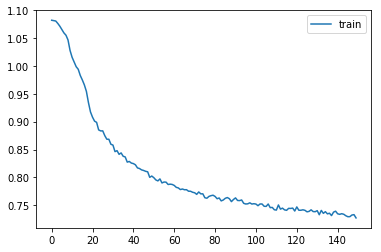

In [43]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [44]:
score = rnn.evaluate(
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    [
        Y_test_is_spike_onehot
    ])

print('\n')
print("Accuracy: %.2f%%" % (score[1]*100))

4448/4520 [============================>.] - ETA: 0s

Accuracy: 38.23%


### To test if Google Trends actually have any benefit in predicting spikes, I ran one with and without the trend data as input. 

#### For "Is Spike" cutoff of 0.1, (meaning Is Spike marks only the 10% biggest changes)
    * With trend data, accuracy was 78.90% on test data.
    * Without trend data, accuracy was 82.93% on test data.
    
#### For "Is Spike" cutoff of 0.3, 
    * With trend data, accuracy was 84.57% for epoch=40 and 89.69% for epoch=60, and 87.98% for epoch=100
    * Without trend data, accuracy was 78.40% for epoch=40 and 88.88% for epoch=60, and 93.60% for epoch=100
    
    Thus Google Trends actually helped Is Spike in the latter case!!!! 
    
    
    * Accuracy on test data is much better than that of train data 
        * -> could be because the test data is statistically different than train data 
            * which makese sense because test data is the real big spike 
                    * Since I am using 10 hours of data to predict the next hour, it would make sense that the accuracy is good during this time since this is the time that people were looking up Bitcoin and perhaps buying them a few hours later 
                * get more up-to-date data 
        * OR BECAUSE TRAIN AND TEST DATA SOMEHOW OVERLAPS?
        
#### With updated data
    * With trend data, accuracy was 45.12% for epoch=100, 45.56% for epoch=200 -> overfitting?
        * -> put in dropout 
    - Without trend data, accuracy was 43.11% for epoch=100, 43/97% for epoch=200
    
    * with the updated data, the test data is now from December 20th, which is right after the massive spike already happened
    
#### With Updated Data and with Dropout of 0.2 
    * With trend data, accuracy was 38.61% for epoch=150
    * Without trend data, accuracy was 38.87% for epoch=150
    
    TODO: Increase data_length (memory in LSTM) and change dropout 
    
#### Increasing data_length to 20 (with dropout)
    * With trend data, accuracy was 38.23% with epoch=150
    
#### Data_length of 20 without dropout 
    * With trend data, accuracy was X% with epoch=100

In [19]:
yhat = rnn.predict( 
    [
        #X_test_timestamp,
        X_test_volume,
        X_test_trends,
        X_test_lagged_price
    ],
    verbose=0
)

display(yhat)

inverted_yhat = np.argmax(yhat,axis=1) #returns INDICES of max 
onehot_to_val_dict = {0: 0, 1: 1, 2:-1 }

inverted_yhat_arr = np.asarray(inverted_yhat)
predicted = [onehot_to_val_dict[i] for i in inverted_yhat_arr]


df_pred_output = pd.DataFrame(predicted, columns=['predicted'])
df_pred_output['actual'] = Y_test_is_spike
#df_pred_output['index_output'] = inverted_yhat
display(df_pred_output.head(100))

correct = (df_pred_output['actual'].values == df_pred_output['predicted'].values)
accuracy = correct.sum() / correct.size
display(accuracy)

array([[ 0.02534344,  0.05034934,  0.92430729],
       [ 0.03313668,  0.90681744,  0.06004593],
       [ 0.43258792,  0.43481657,  0.1325956 ],
       ..., 
       [ 0.37551153,  0.06019156,  0.56429696],
       [ 0.53921092,  0.44531742,  0.01547169],
       [ 0.17624743,  0.30557993,  0.51817256]], dtype=float32)

,predicted,actual
0,-1,-1.0
1,1,1.0
2,1,1.0
3,-1,-1.0
4,1,1.0
5,1,1.0
6,-1,-1.0
7,-1,-1.0
8,-1,-1.0
9,-1,-1.0


0.45121412803532007

In [20]:
# serialize model to JSON# serial 
model_json = rnn.to_json()
with open("model_classification.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
rnn.save_weights("model_classification.h5")

In [21]:
from sklearn import metrics

#print(metrics.confusion_matrix(df_pred_output['actual'].values, df_pred_output['predicted'].values,labels=[0,1,-1]))

confusion_matrix = pd.crosstab(df_pred_output['actual'].values, df_pred_output['predicted'].values, rownames=['Actual'], colnames=['Predicted'], margins=True)

display(confusion_matrix)

Predicted,-1,0,1,All
Actual,,,,
-1.0,808,298,628,1734
0.0,333,476,382,1191
1.0,500,345,760,1605
All,1641,1119,1770,4530


In [40]:
# need to check what the rnn actually learned 
# visualize predicted vs actual to get insight into this 

# try with instead of just 10% biggest changes, maybe with 25% 
# is it just learning from the previous prices, or is google trends actually helping 
# -> run rnn without google trends 


# I have a master_df_v2 now so try that - this one has 0.3 as cutoff for is Spike 
# Have to eventually get validation data - also get overall newer more data 